In [1]:
import os
os.environ['http_proxy'] = 'http://proxy1.bgc-jena.mpg.de:3128' 
os.environ['https_proxy'] = 'http://proxy1.bgc-jena.mpg.de:3128'

FILES TO UPDATE: 
- config.yaml
- params.yaml
- entity
- configuration manager in src config
- components
- pipeline
- main.py
- app.py

In [2]:
os.chdir('../')
%pwd

'/Net/Groups/BGI/scratch/ppandey/Side_Quest/semantic-land-segment-hf'

In [77]:
from dataclasses import dataclass
from pathlib import Path

@dataclass(frozen=True)
class DataLoaderConfig:
    root_dir: Path
    preprocessed_data_path: Path
    BACKBONE: str
    pretrained: str
    n_classes: int
    batch_size: int

In [78]:
from landcover_segmentation.constants import *
from landcover_segmentation.utils.common import create_directories, read_yaml

In [85]:
class ConfigurationManager:
    def __init__(
        self,
        config_filepath = CONFIG_FILEPATH,
        params_filepath = PARAMS_FILEPATH
    ):
        self.config = read_yaml(config_filepath)
        self.params = read_yaml(params_filepath)

        # create artifacts folder
        create_directories([self.config.artifacts_root])

    def get_data_loader_config(self) -> DataLoaderConfig:
        config = self.config.data_loader
        params = self.params.SegmentationModelArguements

        # create directory
        create_directories([config.root_dir])

        data_loader_config = DataLoaderConfig(
            root_dir=config.root_dir,
            preprocessed_data_path=config.preprocessed_data_path,
            BACKBONE=params.BACKBONE,
            pretrained=params.pretrained,
            n_classes=params.n_classes,
            batch_size=params.batch_size
        )

        return data_loader_config

In [86]:
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn.functional as F
from torch.utils.data import Dataset
from torchvision import transforms
from torch.utils.data import DataLoader
from torch.utils.data import Dataset as BaseDataset

from sklearn.preprocessing import MinMaxScaler, StandardScaler
from keras.utils import to_categorical

import segmentation_models_pytorch as smp
from segmentation_models_pytorch.encoders import get_preprocessing_fn

import cv2
from PIL import Image

import albumentations as albu
from albumentations.pytorch import ToTensorV2

from landcover_segmentation.logging import logger

In [87]:
class DataLoaderSegmentation(torch.utils.data.Dataset):
    def __init__(
        self, 
        imgs_path,
        masks_path,
        transform=None
    ):
        super().__init__()
        self.imgs_path = imgs_path
        self.imgs_list = os.listdir(imgs_path)

        self.masks_path = masks_path
        self.masks_list = os.listdir(masks_path)

        self.transform = transform

    def __len__(self):
        return len(self.imgs_list)
    
    def __getitem__(self, idx):
        img_path = os.path.join(self.imgs_path, self.imgs_list[idx])
        mask_path = os.path.join(self.masks_path, self.masks_list[idx])

        image = cv2.imread(img_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
        
        if self.transform is not None:
            augmented = self.transform(image=image, mask=mask)
            image = augmented['image']
            mask = augmented['mask']
                
        return image, mask
    
    def get_image_paths(self):
        return [os.path.join(self.imgs_path, img) for img in self.imgs_list]


[[0.41326531 0.33149171 0.32738096]
 [0.40816327 0.32596685 0.32142858]
 [0.38265306 0.31491713 0.30357144]
 [0.39285715 0.32596685 0.3154762 ]
 [0.39285715 0.33701657 0.32142858]
 [0.39795919 0.34254144 0.32738096]
 [0.42346939 0.37016574 0.35714286]
 [0.42857143 0.37569061 0.36309524]
 [0.40816327 0.36464088 0.3452381 ]
 [0.38265306 0.33701657 0.3154762 ]
 [0.40816327 0.35359116 0.33928572]
 [0.41326531 0.35911602 0.3452381 ]
 [0.40816327 0.34254144 0.33333334]
 [0.39795919 0.33149171 0.32142858]
 [0.35714286 0.28729282 0.27380951]
 [0.33163266 0.25966851 0.24404761]
 [0.3367347  0.2762431  0.25595237]
 [0.33163266 0.27071824 0.24999999]
 [0.35204082 0.29281768 0.27380951]
 [0.37755102 0.32044199 0.30357144]
 [0.37244898 0.31491713 0.29761906]
 [0.36734694 0.30939227 0.29166668]
 [0.3877551  0.34254144 0.30952382]
 [0.40816327 0.36464088 0.33333334]
 [0.39795919 0.35359116 0.33333334]
 [0.3877551  0.35359116 0.33333334]
 [0.37244898 0.33701657 0.3154762 ]
 [0.3367347  0.30939227 0.27

(-0.5, 255.5, 255.5, -0.5)

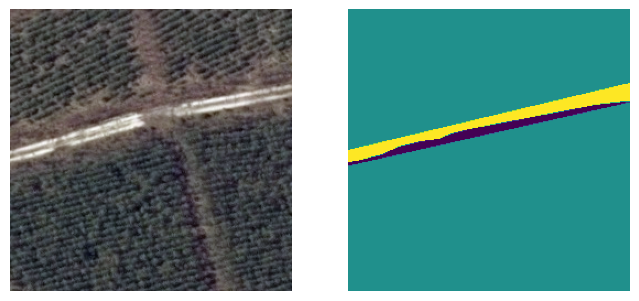

In [88]:
transform = albu.Compose([
    albu.HorizontalFlip(p=0.5),
    albu.VerticalFlip(p=0.5),
    albu.RandomRotate90(p=0.5),
    ToTensorV2()
])

# img = Image.open(
#     '/Net/Groups/BGI/scratch/ppandey/Side_Quest/semantic-land-segment-hf/artifacts/data_preprocessing/final_dataset/train_images/train/M-33-7-A-d-2-3_patch_0_7.tif'
# ).convert('RGB')

# mask = Image.open(
#     '/Net/Groups/BGI/scratch/ppandey/Side_Quest/semantic-land-segment-hf/artifacts/data_preprocessing/final_dataset/train_masks/train/M-33-7-A-d-2-3_patch_0_7.tif'
# ).convert('L')

image = cv2.imread('/Net/Groups/BGI/scratch/ppandey/Side_Quest/semantic-land-segment-hf/artifacts/data_preprocessing/final_dataset/train_images/train/M-33-7-A-d-2-3_patch_1_15.tif'
)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
mask = cv2.imread('/Net/Groups/BGI/scratch/ppandey/Side_Quest/semantic-land-segment-hf/artifacts/data_preprocessing/final_dataset/train_masks/train/M-33-7-A-d-2-3_patch_1_15.tif'
, cv2.IMREAD_GRAYSCALE)

augmented = transform(image=image, mask=mask)
img = augmented['image']
mask = augmented['mask']

preprocess_input = get_preprocessing_fn('resnet34', pretrained='imagenet')

img = preprocess_input(img.permute(1,2,0))
scaler = MinMaxScaler()
img = scaler.fit_transform(img.reshape(-1, img.shape[-1])).reshape(img.shape)
# img = preprocess_input(img) 
print(img[1])
# img['image']
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(8, 4))
ax1.imshow(img)
ax1.axis(False)
ax2.imshow(mask)
ax2.axis(False)

In [89]:
class SegDataLoader:
    def __init__(
        self,
        config: DataLoaderConfig
    ):
        self.config = config
        self.preprocess_input = get_preprocessing_fn(self.config.BACKBONE, pretrained=self.config.pretrained)

    def add_single_img_processing(self, img, mask):
        num_class = self.config.n_classes
        
        img = img.permute(0, 2, 3, 1)

        scaler = MinMaxScaler()
        img = scaler.fit_transform(img.reshape(-1, img.shape[-1])).reshape(img.shape)
        img = self.preprocess_input(img)  # Preprocess based on the pretrained backbone...
        
        # Convert mask to one-hot encoding
        mask = F.one_hot(mask.to(torch.int64), num_class)  # Convert to one-hot
        
        return img, mask

    def TrainGenerator(self, data_type: str):
        transform = albu.Compose([
            albu.HorizontalFlip(p=0.5),
            albu.VerticalFlip(p=0.5),
            albu.RandomRotate90(p=0.5),
            ToTensorV2()
        ])

        if data_type=='train':
            dataset = DataLoaderSegmentation(
                imgs_path=os.path.join(self.config.preprocessed_data_path, 'train_images', data_type),
                masks_path=os.path.join(self.config.preprocessed_data_path, 'train_masks', data_type),
                transform=transform
            )

        elif data_type=='test':
            dataset = DataLoaderSegmentation(
                imgs_path=os.path.join(self.config.preprocessed_data_path, 'test_images', data_type),
                masks_path=os.path.join(self.config.preprocessed_data_path, 'test_masks', data_type),
                transform=transform
            )
            
        elif data_type=='val':
            dataset = DataLoaderSegmentation(
                imgs_path=os.path.join(self.config.preprocessed_data_path, 'val_images', data_type),
                masks_path=os.path.join(self.config.preprocessed_data_path, 'val_masks', data_type),
                transform=transform
            )
        

        train_loader = DataLoader(
            dataset=dataset,
            batch_size=self.config.batch_size,
            shuffle=True,
            num_workers=8,
            drop_last=True,
            worker_init_fn=lambda _: torch.manual_seed(24)
        )

        for img, mask in train_loader:
            print(mask.shape)
            img, mask = self.add_single_img_processing(img=img, mask=mask)
            yield (img, mask)

In [90]:
try:
    config = ConfigurationManager()
    data_loader_config = config.get_data_loader_config()
    data_loader = SegDataLoader(config=data_loader_config)
    train_generator = data_loader.TrainGenerator(data_type='train')
except Exception as e:
    raise e

[2024-06-02 16:27:33,303: INFO: common: yaml file: config/config.yaml loaded successfully]
[2024-06-02 16:27:33,381: INFO: common: yaml file: params.yaml loaded successfully]
[2024-06-02 16:27:33,387: INFO: common: created directory at: artifacts]
[2024-06-02 16:27:33,388: INFO: common: created directory at: artifacts/data_loader]


In [91]:
x, y = next(train_generator)

torch.Size([4, 256, 256])


In [92]:
y.shape, x.shape

(torch.Size([4, 256, 256, 5]), (4, 256, 256, 3))

[2024-06-02 16:27:36,738: WARNING: image: Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).]


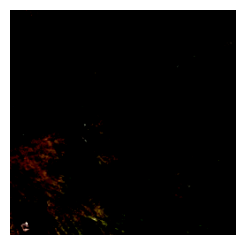

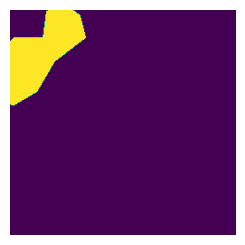

[2024-06-02 16:27:37,007: WARNING: image: Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).]


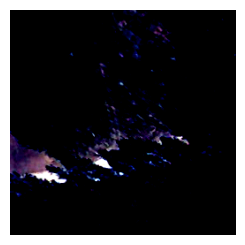

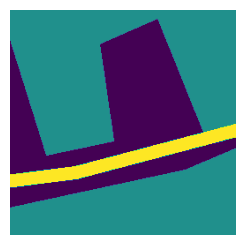

[2024-06-02 16:27:37,150: WARNING: image: Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).]


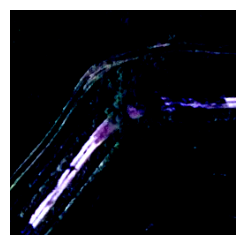

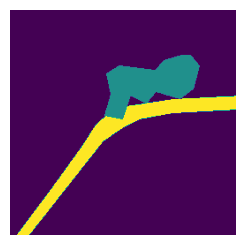

[2024-06-02 16:27:37,284: WARNING: image: Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).]


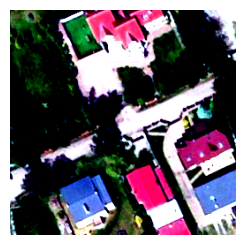

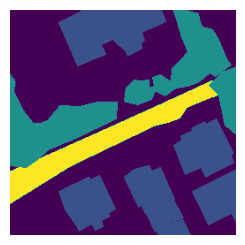

In [93]:
for i in range(0,4):
    image = x[i]
    mask = np.argmax(y[i], axis=2)
    plt.subplot(1,2,1)
    plt.imshow(image)
    plt.axis(False)
    plt.show()
    plt.subplot(1,2,2)
    plt.imshow(mask)
    plt.axis(False)
    plt.show()